# 31 Pytorch & NetworkX
---

Jonnatan Arias Garcia

jariasg@uniquindio.edu.co

jonnatan.arias@utp.edu.co

# Pytorch

- Datasets
- Models
- Losses
- Optimizers

Official resources:
* [Deep Learning with PyTorch: a 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [PyTorch documentation](https://pytorch.org/docs/stable/index.html)

## Imports

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams.update({'font.size': 16})

In [2]:
x = torch.rand(20, 5)
x
((x.norm(dim=1) - 1).abs() < 1e-10).float()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Datasets

Los datos son obtenidos del modelo
$$
x \mapsto y:=Ax + b
$$
con $x\in\mathbb R^{input\_dim}$ y $y\in\mathbb R^{output\_dim}$.

In [3]:
input_dim = 1
output_dim = 1

A = 2 * np.random.rand(output_dim, input_dim) - 1
b = 2 * np.random.rand(output_dim) - 1

true_model = lambda x: A @ x + b

Obtenemos el conjunto de entrenamiento aleatoriamente con ruido

\begin{align*}
&x_i \sim U([-1, 1])\\
&y_i = A x_i + b + \nu_i
\end{align*}

In [4]:
n_train = 1000
noise_level = 0.04

# Generate a random set of n_train samples
X_train = np.random.rand(n_train, input_dim)
y_train = np.array([true_model(x) for x in X_train])

# Add some noise
y_train += noise_level * np.random.standard_normal(size=y_train.shape)

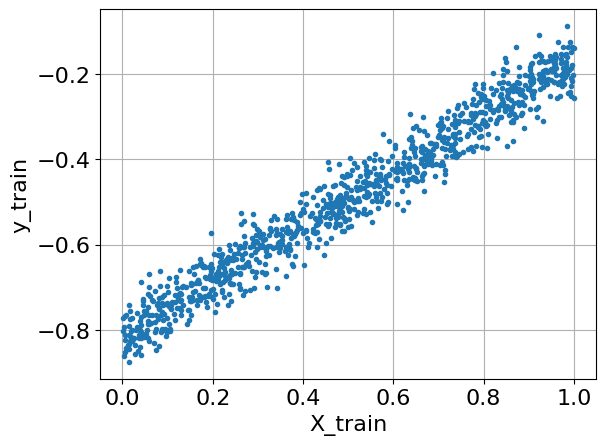

In [5]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(X_train, y_train, '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.set_ylabel('y_train')

## PyTorch `Dataset`

In [6]:
#%% Dataset to manage vector to vector data
class VectorialDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, output_data):
        super(VectorialDataset, self).__init__()
        self.input_data = torch.tensor(input_data.astype('f'))
        self.output_data = torch.tensor(output_data.astype('f'))

    def __len__(self):
        return self.input_data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = (self.input_data[idx, :],
                  self.output_data[idx, :])
        return sample

In [21]:
training_set = VectorialDataset(input_data=X_train, output_data=y_train)

In [16]:
len(training_set)

1000

In [22]:
training_set[10:12]

(tensor([[0.4303],
         [0.5887]]),
 tensor([[-0.5063],
         [-0.5007]]))

## PyTorch `DataLoader`

In [23]:
batch_size = 120
train_loader = torch.utils.data.DataLoader(training_set,
                                           batch_size=batch_size,
                                           shuffle=True)

El rol del batch_size:

In [24]:
for idx, batch in enumerate(train_loader):
    print('Batch n. %2d: input size=%s, output size=%s' % (idx+1, batch[0].shape, batch[1].shape))

Batch n.  1: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  2: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  3: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  4: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  5: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  6: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  7: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  8: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  9: input size=torch.Size([40, 1]), output size=torch.Size([40, 1])


In [27]:
8 * 120 + 40

1000

El rol de shuffle:

In [ ]:
first_batch = []

for epoch in range(2):
    for idx, batch in enumerate(train_loader):
        if idx == 0:
            first_batch.append(batch)

np.c_[X_train[:batch_size], first_batch[0][0].numpy(), first_batch[1][0].numpy()]

## Models

Implementamos un modelo lineal $$x \mapsto model(x):=A x + b$$

con $A\in \mathbb{R}^{input\_dim\times output\_dim}$, $b\in\mathbb{R}^{output\_dim}$.

In [29]:
import torch.nn as nn
import torch

#%% Linear layer
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.linear = nn.Linear(self.input_dim, self.output_dim, bias=True)

    def forward(self, x):
        out = self.linear(x)
        return out

    def reset(self):
        self.linear.reset_parameters()

In [30]:
model = LinearModel(input_dim, output_dim)

### Model Inspection

In [31]:
print(model)

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


 [pytorch.org/docs/stable/nn.html](https://pytorch.org/docs/stable/nn.html) para info de mas tipo de capaz

In [32]:
list(model.parameters())

[Parameter containing:
 tensor([[0.9617]], requires_grad=True),
 Parameter containing:
 tensor([0.8359], requires_grad=True)]

In [33]:
model.linear.weight

Parameter containing:
tensor([[0.9617]], requires_grad=True)

In [34]:
model.linear.bias

Parameter containing:
tensor([0.8359], requires_grad=True)

### el metodo Forward

In [35]:
x = torch.randn(5, input_dim)
model.forward(x)

tensor([[1.8660],
        [0.2360],
        [1.9260],
        [0.7132],
        [1.6332]], grad_fn=<AddmmBackward0>)

In [36]:
[model.linear.weight @ xx + model.linear.bias for xx in x]

[tensor([1.8660], grad_fn=<AddBackward0>),
 tensor([0.2360], grad_fn=<AddBackward0>),
 tensor([1.9260], grad_fn=<AddBackward0>),
 tensor([0.7132], grad_fn=<AddBackward0>),
 tensor([1.6332], grad_fn=<AddBackward0>)]

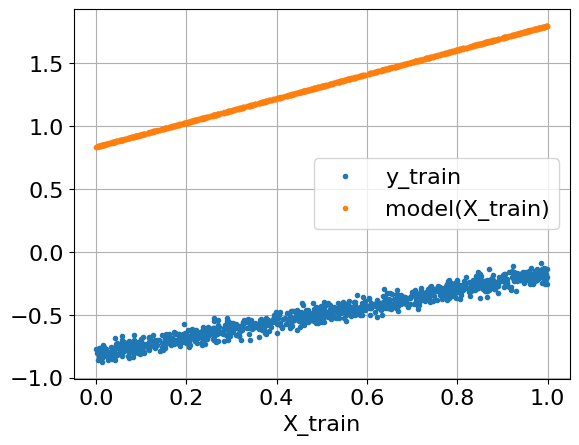

In [38]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(training_set.input_data, training_set.output_data, '.')
    ax.plot(training_set.input_data, model.forward(training_set.input_data).detach().numpy(), '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.legend(['y_train', 'model(X_train)'])

## Losses

MSE loss es
$$
L(y, y') = \|y-y'\|_2^2
$$

In [39]:
import torch.nn as nn
loss_fun = nn.MSELoss(reduction='mean')

Mas Loss en [pytorch.org/docs/stable/nn.html#loss-functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [40]:
x = torch.tensor(np.array([1, 2, 1]).astype('f'))
z = torch.tensor(np.array([0, 0, 0]).astype('f'))
loss_fun(x, z)

tensor(2.)

## Dando un score al modelo (parametros) oara el conjunto de entrenamiento

El loss para un par de datos $(x_i, y_i)$ es
$$
L(model(x_i), y_i)
$$

El promedio del loss en el conjunto de entrenamiento es
$$
L(X_{train}, y_{train}):=\frac{1}{n_{train}} \sum_{i=1}^{n_{train}} L(model(x_i), y_i)
$$

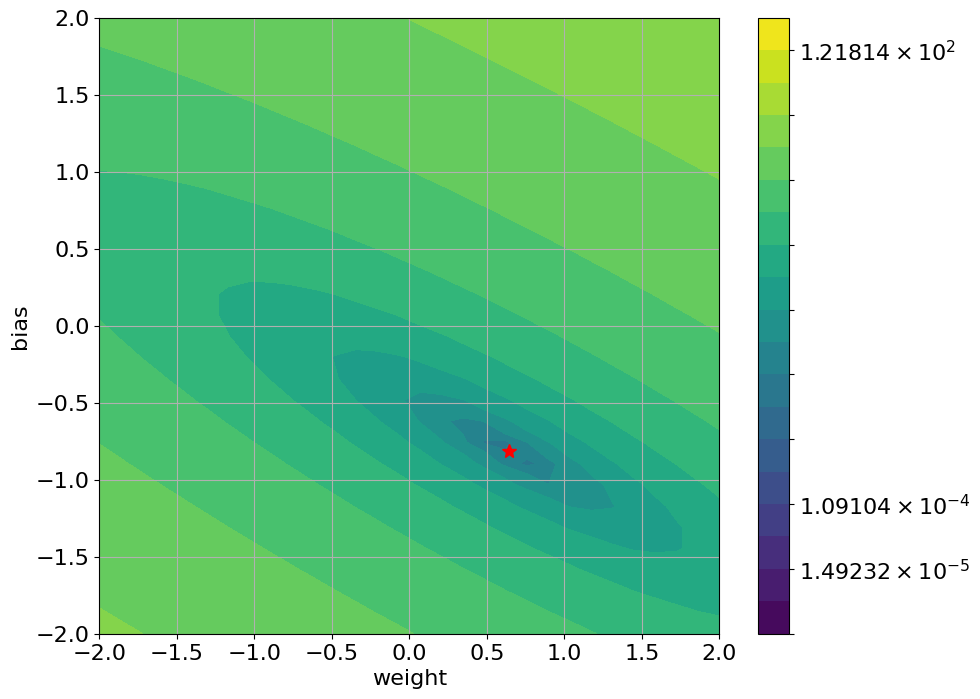

In [42]:
if input_dim == output_dim == 1:

    state_dict = model.state_dict()

    ww, bb = np.meshgrid(np.linspace(-2, 2, 30), np.linspace(-2, 2, 30))

    loss_values = 0 * ww
    for i in range(ww.shape[0]):
        for j in range(ww.shape[1]):
            state_dict['linear.weight'] = torch.tensor([[ww[i, j]]])
            state_dict['linear.bias'] = torch.tensor([bb[i, j]])
            model.load_state_dict(state_dict)
            loss_values[i, j] = loss_fun(model.forward(training_set.input_data),  training_set.output_data)

    fig = plt.figure(figsize=(10, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    c=ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    plt.colorbar(c)
    ax.plot(A[0], b, 'r*', markersize=10)
    ax.set_ylabel('bias')
    ax.set_xlabel('weight')
    # ax.legend(['(A, b)'])

    ax.grid(True)

## Optimización

Objetivo: minimiza el loss dados los datos::
$$
\min\limits_{par \in model} L(X_{train}, y_{train})
=\min\limits_{par \in model} \frac{1}{n_{train}} \sum_{i=1}^{n_{train}} L(x_i, model(x_i))
$$

En este caso $par =\{A, b\}$.

Iterative gradient based optimization:
\begin{align*}
par^{(0)} &= par_0\\
par^{(k+1)} &=  par^{(k)} - \eta^{(k)} \nabla_{par} L(X_{train}, y_{train})
\end{align*}    
Con learning rate $\eta^{(k)}$.

### Gradientes

El modelo es
$$
model(x) = A x + b
$$

Con $input\_dim = output\_dim = 1$ tenemos $A:=a\in\mathbb{R},\ b\in\mathbb{R}$.

Para un par de datos $(x, y)$ el loss es
\begin{align*}
L(x, y)
&= \|model(x)-y\|_2^2\\
&= (model(x)-y)^2\\
&= (a x + b - y)^2\\
&= a^2 x^2 + 2 a b x - 2 a xy + b^2 -2 b y + y^2.
\end{align*}

Podemos computar
\begin{align*}
\nabla_a L(x, y)
&= 2 a x^2 + 2 b x - 2 xy
=2 x (a x + b - y)\\
\nabla_b L(x, y)
&= 2 a x + 2 b - 2 y
= 2 (ax + b - y).
\end{align*}


In [43]:
x = torch.randn(1, input_dim)
y =  torch.randn(1, output_dim)

model.zero_grad()
loss = loss_fun(model.forward(x),  y)
loss.backward()

In [44]:
if input_dim == output_dim == 1:
    print(model.linear.weight.grad)
    print(2 * x * (model.linear.weight * x + model.linear.bias - y))

    print(model.linear.bias.grad)
    print(2 * (model.linear.weight * x + model.linear.bias - y))

tensor([[32.2753]])
tensor([[32.2753]], grad_fn=<MulBackward0>)
tensor([13.4367])
tensor([[13.4367]], grad_fn=<MulBackward0>)


Optimización a mano

In [45]:
if input_dim == output_dim == 1:

    num_iter = 200
    lr = 0.5 # 0.01

    train_hist = {}
    train_hist['weight'] = []
    train_hist['bias'] = []

    model.reset()
    state_dict = model.state_dict()

    for _ in range(num_iter):

        model.zero_grad()
        loss = loss_fun(model.forward(training_set.input_data), training_set.output_data)
        loss.backward()

        w = model.linear.weight.item()
        b = model.linear.bias.item()

        dw = model.linear.weight.grad.item()
        db = model.linear.bias.grad.item()

        state_dict['linear.weight'] += torch.tensor([-lr * dw])
        state_dict['linear.bias'] += torch.tensor([-lr * db])
        model.load_state_dict(state_dict)

        train_hist['weight'].append(w)
        train_hist['bias'].append(b)

    for label in train_hist:
        train_hist[label] = np.array(train_hist[label])

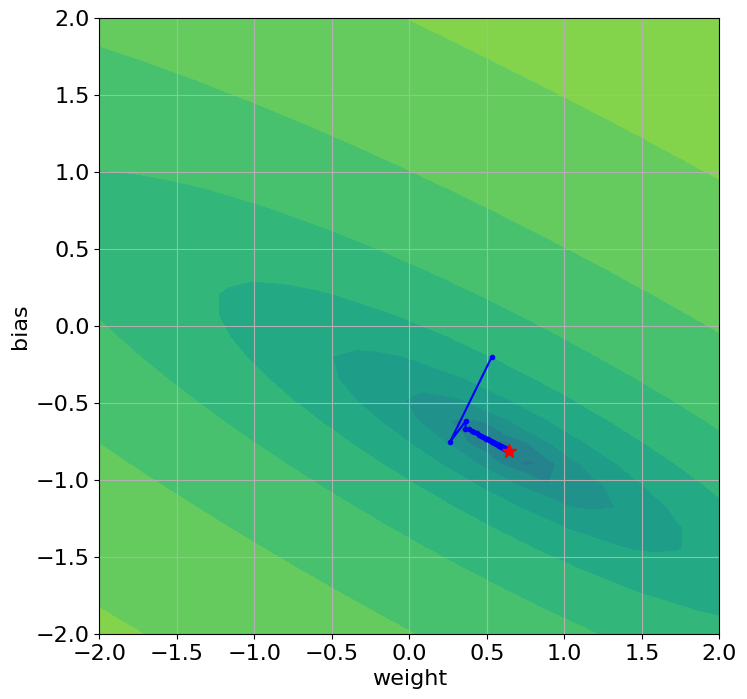

In [46]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(8, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    ax.grid(True)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(A[0], b, 'r*', markersize=10)

    #ax.legend(['optim', '(A, b)'])

### SGD gradiente estocastico

* Evita cargar el conjunto de entrenamiento completo
* Evita evaluar el modelo en el conjunto de entrenamiento completo

A cada paso, computa le perdida en un batch de la data
 $(X^{(k)}, y^{(k)})\sim (X_{train}, y_{train})$:

\begin{align*}
L(X^{(k)}, y^{(k)}) := \sum_{(x, y) \in (X^{(k)}, y^{(k)})} L(x, model(x)).
\end{align*}    

y actualiza con el gradiente aproximado:
\begin{align*}
par^{(k+1)} &=  par^{(k)} - \eta^{(k)} \nabla_{par} L(X^{(k)}, y^{(k)}).
\end{align*}    

## PyTorch `optim`

In [47]:
lr = 0.1
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

Mas en [pytorch.org/docs/stable/optim.html](https://pytorch.org/docs/stable/optim.html).

In [48]:
n_epochs = 100

In [49]:
train_hist = {}
train_hist['loss'] = []

if input_dim == output_dim == 1:
    train_hist['weight'] = []
    train_hist['bias'] = []

# Initialize training
model.reset()
model.train()

for epoch in range(n_epochs):
    for idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        loss = loss_fun(model.forward(batch[0]),  batch[1])
        loss.backward()
        optimizer.step()

        train_hist['loss'].append(loss.item())
        if input_dim == output_dim == 1:
            train_hist['weight'].append(model.linear.weight.item())
            train_hist['bias'].append(model.linear.bias.item())

        print('[Epoch %4d/%4d] [Batch %4d/%4d] Loss: % 2.2e' % (epoch + 1, n_epochs,
                                                                idx + 1, len(train_loader),
                                                                loss.item()))

model.eval()

[Epoch    1/ 100] [Batch    1/   9] Loss:  1.11e-01
[Epoch    1/ 100] [Batch    2/   9] Loss:  7.19e-02
[Epoch    1/ 100] [Batch    3/   9] Loss:  4.50e-02
[Epoch    1/ 100] [Batch    4/   9] Loss:  5.17e-02
[Epoch    1/ 100] [Batch    5/   9] Loss:  6.36e-02
[Epoch    1/ 100] [Batch    6/   9] Loss:  5.88e-02
[Epoch    1/ 100] [Batch    7/   9] Loss:  4.74e-02
[Epoch    1/ 100] [Batch    8/   9] Loss:  2.64e-02
[Epoch    1/ 100] [Batch    9/   9] Loss:  1.96e-02
[Epoch    2/ 100] [Batch    1/   9] Loss:  1.63e-02
[Epoch    2/ 100] [Batch    2/   9] Loss:  1.69e-02
[Epoch    2/ 100] [Batch    3/   9] Loss:  2.29e-02
[Epoch    2/ 100] [Batch    4/   9] Loss:  1.88e-02
[Epoch    2/ 100] [Batch    5/   9] Loss:  1.35e-02
[Epoch    2/ 100] [Batch    6/   9] Loss:  1.16e-02
[Epoch    2/ 100] [Batch    7/   9] Loss:  8.04e-03
[Epoch    2/ 100] [Batch    8/   9] Loss:  4.47e-03
[Epoch    2/ 100] [Batch    9/   9] Loss:  3.40e-03
[Epoch    3/ 100] [Batch    1/   9] Loss:  3.76e-03
[Epoch    3/

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [50]:
if input_dim == output_dim == 1:
    n_test = 500
    X_test = np.random.rand(n_test, input_dim)
    y_pred = []

    state_dict = model.state_dict()

    for idx in range(len(train_hist['weight'])):
        state_dict['linear.weight'] = torch.tensor([[train_hist['weight'][idx]]])
        state_dict['linear.bias'] = torch.tensor([train_hist['bias'][idx]])
        model.load_state_dict(state_dict)

        y_pred.append(model.forward(torch.tensor(X_test.astype('f'))).detach().numpy())

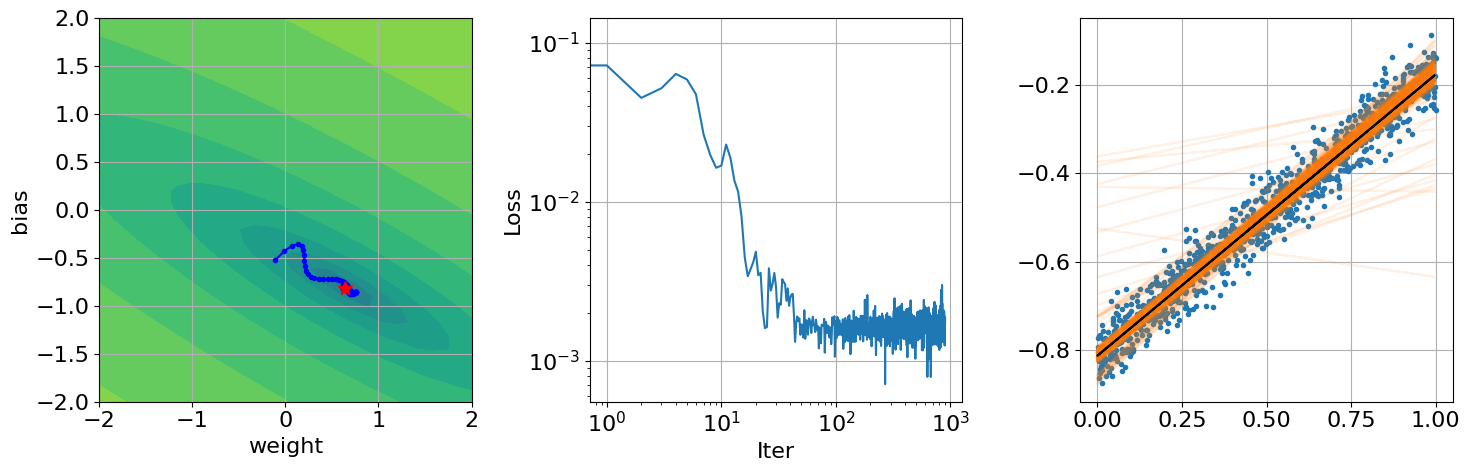

In [51]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(15, 5))
    fig.clf()

    ax = fig.add_subplot(1, 3, 1)
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(A[0], b, 'r*', markersize=10)
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    #ax.legend(['optim', '(A, b)'])
    ax.grid(True)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

    ax = fig.add_subplot(1, 3, 2)
    ax.loglog(np.abs(train_hist['loss']))
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.grid(True)

    ax = fig.add_subplot(1, 3, 3)
    ax.plot(X_train, y_train, '.')
    a=ax.plot(X_test, y_pred[0], '-', alpha=0.1)
    for y in y_pred[1:]:
        ax.plot(X_test, y, '-', alpha=0.1, color=a[0].get_color())
    ax.plot(X_test, y_pred[-1], 'k')
    ax.grid(True)

    fig.tight_layout()

else:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.loglog(np.abs(train_hist['loss']))
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.grid(True)

# NetworkX

NetworkX es un paquete de software en lenguaje Python para la creación, manipulación y estudio de la estructura, dinámica y función de redes complejas.

Con NetworkX puede cargar y almacenar redes en formatos de datos estándar y no estándar, generar muchos tipos de redes clásicas y aleatorias, analizar la estructura de la red, construir modelos de red, diseñar nuevos algoritmos de red, dibujar redes y mucho más.

Library documentation: <a>https://networkx.github.io/</a>

In [52]:
import networkx as nx
G = nx.Graph()

In [54]:
# basic add nodes
G.add_node(1)
G.add_nodes_from([2, 3])

In [53]:
# add a group of nodes at once
H = nx.path_graph(10)
G.add_nodes_from(H)

In [55]:
# add another graph itself as a node
G.add_node(H)

In [56]:
# add edges using similar methods
G.add_edge(1, 2)
e = (2, 3)
G.add_edge(*e)
G.add_edges_from([(1, 2), (1, 3)])
G.add_edges_from(H.edges())

In [57]:
# can also remove or clear
G.remove_node(H)
G.clear()

In [58]:
# repeats are ignored
G.add_edges_from([(1,2),(1,3)])
G.add_node(1)
G.add_edge(1,2)
G.add_node('spam')       # adds node "spam"
G.add_nodes_from('spam') # adds 4 nodes: 's', 'p', 'a', 'm'

In [59]:
# get the number of nodes and edges
G.number_of_nodes(), G.number_of_edges()

(8, 2)

In [60]:
# access graph edges
G[1]

AtlasView({2: {}, 3: {}})

In [61]:
G[1][2]

{}

In [62]:
# set an attribute of an edge
G.add_edge(1,3)
G[1][3]['color'] = 'blue'

In [80]:
FG = nx.Graph()
FG.add_weighted_edges_from([(1, 2, 0.125), (1, 3, 0.75), (2, 4, 1.2), (3, 4, 0.375)])
for u, v, data in FG.edges(data=True):
   print('(%d, %d, %.3f)' % (u, v, data['weight']))

(1, 2, 0.125)
(1, 3, 0.750)
(2, 4, 1.200)
(3, 4, 0.375)


In [77]:
FG.edges

EdgeView([(1, 2), (1, 3), (2, 4), (3, 4)])

In [64]:
# graph attribte
G = nx.Graph(day='Friday')
G.graph

{'day': 'Friday'}

In [65]:
# modifying an attribute
G.graph['day'] = 'Monday'
G.graph

{'day': 'Monday'}

In [112]:
# node attributes
G.add_node(1, time='5pm')
G.add_nodes_from([3], time='2pm')
G.nodes[1]['room'] = 714
G.nodes(data=True)

NodeDataView({1: {'time': '5pm', 'room': 714}, 3: {'time': '2pm'}, 2: {}, 4: {}, 5: {}})

In [114]:
# edge attributes (weight is a special numeric attribute)
G.add_edge(1, 2, weight=4.7)
G.add_edges_from([(3, 4), (4, 5)], color='red')
G.add_edges_from([(1, 2 ,{'color': 'blue'}), (2, 3, {'weight' :8})])
G[1][2]['weight'] = 4.7


In [115]:
print(G.get_edge_data(1,2))
G.add_weighted_edges_from([(1,2,4)])
G.get_edge_data(1,2)

{'weight': 4.7, 'color': 'blue'}


{'weight': 4, 'color': 'blue'}

In [70]:
# directed graph
DG = nx.DiGraph()
DG.add_weighted_edges_from([(1, 2 ,0.5), (3, 1, 0.75)])
DG.out_degree(1, weight='weight')

0.5

In [71]:
DG.degree(1, weight='weight')

1.25

In [72]:
DG.successors(1)

In [73]:
DG.predecessors(1)

In [74]:
# convert to undirected graph
H = nx.Graph(G)

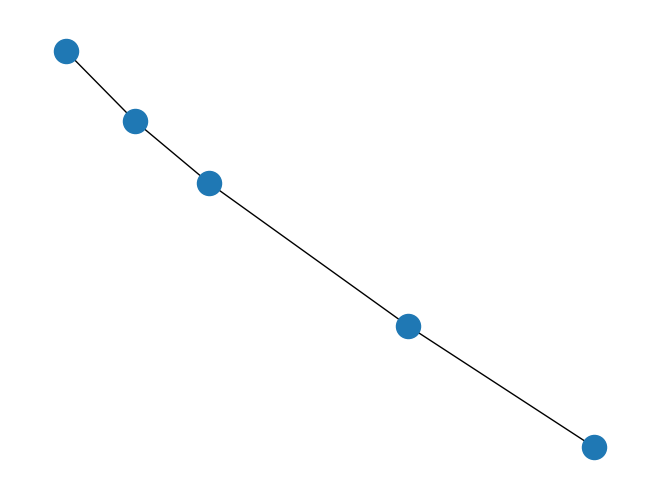

In [75]:
# basic graph drawing capability
%matplotlib inline
import matplotlib.pyplot as plt
nx.draw(G)